# The Audio SUD Analysis Notebook

The PECSS phone and watch application is programmed to gather data from all it's active sensors. With audio data that we gather from the patient's phone/watch when they are in therapy, an obvious question arises:

**Can this audio data give us any sort of 'insights' about the patint?***


#### Essential Readings

While reading relevant research literature, we found two papers to be relevant to our research question: 
1. Speech‐based markers for posttraumatic stress disorder in US veterans (Referred to as the 'Marmar Paper')
2. Recognizing hotspots in Brief Eclectic Psychotherapy for PTSD by text and audio mining (Referred to as the 'Wiegersma Paper')

While the Marmar paper deals with building an intelligent system to classify patients as PTSD +ve or -ve based on their speech, the Wiegersma paper is focussed on finding moments of most discomfort for a PTSD patient.


#### My Thought Process

First of all, SUD = Subjective Unit of Distress. Of all the literature I came across, I couldn't find any work focussing on evaluating the **degree** of distress faced during the imaginal exposure phase. This got me wondering, **How do speech markers compare for a single individual in varying degrees of distress?** 

To answer this question, I created this Jupyter Notebook, which extracts the germane audio features, visualizes them, and then allows us to compare these audio features for different audio snippets with 3 different SUD values (low, high, medium).


#### Features Extracted

1. MFCC
2. Zero Crossings
3. Spectral Centroid
4. Spectrogram
5. Chroma FFT
6. Energy
7. RMS Energy
8. Spectral Rolloff
9. Phonation Rate
10. Speech Productivity
11. Speech Rate
12. Articulation Rate


#### Notebook Structure

I have maintained the following structure throughout the notebook:
1. A brief description of that particular feature is presented.
2. Helper Functions are declared that can be eventually called for a particular audio file.
3. Helper Functions are then called for the 3 audio files, and the extracted values are printed, graphs are plotted to gelp us compare the result. I have also mentioned if I am investigating something from the Marmar or the Wiegersma paper.
4. Observation, if any, are mentioned.

------------------------------------------------------------------------------------------------------------------

**Special thanks to Jennifer and Jiawei for providing me with the correct advice and resources!**

# Starting off: Importing required modules and loading the three audio files

In [2]:
import librosa 
import librosa.display
from scipy.io import wavfile as wav
import speech_recognition as sr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import sklearn
from pydub import AudioSegment 
from pydub.silence import split_on_silence 
import ffmpeg
from sklearn.svm import SVC

#SUD-70
filename1 = 'patient_audio/session1/low_sud_audio.wav' #use p3
duration1 = librosa.get_duration(filename=filename1)

#SUD-85
filename2 = 'patient_audio/session1/medium_sud_audio.wav' #use p12, p13
duration2 = librosa.get_duration(filename=filename2)

#SUD-90
filename3 = 'patient_audio/session1/high_sud_audio.wav' #use p10, p11, p12
duration3 = librosa.get_duration(filename=filename3)

'''
In order to compare the three audio files properly, we should be analyzing equal sizes of audio snippets.
Thus, snipping duration of all three audio files to the minimum of the three files.
'''
audio_duration = min(duration1, duration2, duration3)

min_sud_audio, sample_rate = librosa.load(filename1, duration=audio_duration) 
medium_sud_audio, sample_rate = librosa.load(filename2, duration=audio_duration) 
high_sud_audio, sample_rate = librosa.load(filename3, duration=audio_duration) 

print('Librosa sample rate:', sample_rate)

Librosa sample rate: 22050


# Feature Extraction: Mel-Frequency Cepstral Coefficients (MFCC)

The MFCC is an immensely elaborate concept in itself, and thus might require extra reading to fully understand.
However, to put it in a nutshell, it can be best described as the **rate of change in spectral bands**, i.e, it's the rate of change in various frequencies that are present in the audio. For a detailed and mathematical understanding of MFCC, you check out https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd

The Marmar paper has extensively used this particular feature, so I too extracted it to check how MFCC values differ accross audio files of different SUD values.

In [3]:
# Helper Functions
'''
Creating Helper Function that visualizes the MFCC Values. 
    Param1: The MFCC Array
    Param2: The coefficient you wish to visualize
'''
def mfcc_visualize(mfcc_value, coefficient_number):
    time_interval = audio_duration / mfcc_value.shape[1]
    x_axis = []
    j=0
    for x in range(mfcc_value.shape[1]):
        x_axis.append(j)
        j = j + time_interval 
    plt.bar(x_axis, mfcc_value[coefficient_number], label="MFCC Coefficient-"+str(coefficient_number)+" Visualization")
    plt.legend()
    plt.xlabel('Time Interval')
    plt.ylabel('MFCC Value')
    plt.title("MFCC Coefficient-"+str(coefficient_number))
    plt.show()


'''
Creating Helper Function that calculates the Average of MFCC Values. 
    Param1: The MFCC Array
'''
def mfcc_mean(mfcc_value):
    return np.mean(mfcc_value)


'''
Creating Helper Function that calculates the Variance of MFCC Values. 
    Param1: The MFCC Array
    Param2: The coefficient
'''
def mfcc_variance(mfcc_value, coefficient_number):
    return np.var(mfcc_value[coefficient_number], dtype = np.float32)


'''
Creating Helper Function that calculates time distance between Maximum & Minimum MFCC Values. 
    Param1: The MFCC Array
    Param2: The coefficient
'''
def mfcc_max_min_time_distance(mfcc_value, coefficient_number):
    time_interval = audio_duration / mfcc_value.shape[1]
    v = mfcc_value[coefficient_number]
    maximum = np.max(v)
    minimum = np.min(v)

    max_index = np.where(v == maximum)
    min_index = np.where(v == minimum)
    
    return (abs(time_interval*(min_index[0]-max_index[0])))

In [4]:
# Extracting MFCC Values
mfccs_min_sud = librosa.feature.mfcc(y=min_sud_audio, sr=sample_rate, n_mfcc=20)
mfccs_medium_sud = librosa.feature.mfcc(y=medium_sud_audio, sr=sample_rate, n_mfcc=20)
mfccs_high_sud = librosa.feature.mfcc(y=high_sud_audio, sr=sample_rate, n_mfcc=20)

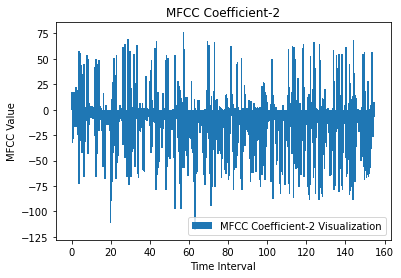

Relative Time Distance between Max and Min values of 2nd Coefficent: [5.99000977]


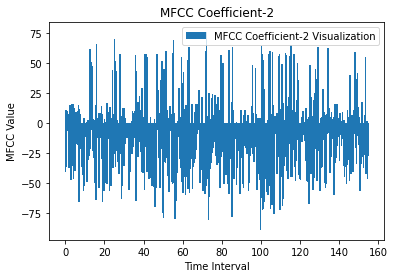

Relative Time Distance between Max and Min values of 2nd Coefficent: [27.65155673]


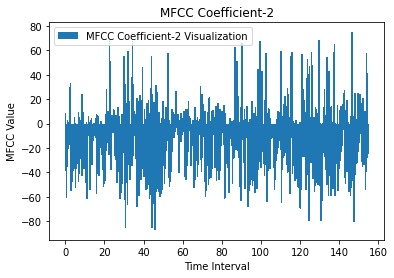

Relative Time Distance between Max and Min values of 2nd Coefficent: [100.59966022]


In [5]:
'''
Feature #2 from Marmar Paper (Monotonous speech segments): 
relative time distance between the maximum and
the minimum values for a specific spectral feature (second LMFCC coefficient),
representing variability in certain speech frequencies.
'''

# For SUD-70 Audio
mfcc_visualize(mfccs_min_sud, 2)
print("Relative Time Distance between Max and Min values of 2nd Coefficent: "+str(mfcc_max_min_time_distance(mfccs_min_sud, 2)))

# For SUD-85 Audio
mfcc_visualize(mfccs_medium_sud, 2)
print("Relative Time Distance between Max and Min values of 2nd Coefficent: "+str(mfcc_max_min_time_distance(mfccs_medium_sud, 2)))

# For SUD-90 Audio
mfcc_visualize(mfccs_high_sud, 2)
print("Relative Time Distance between Max and Min values of 2nd Coefficent: "+str(mfcc_max_min_time_distance(mfccs_high_sud, 2)))

## Conclusion for MFCC 2nd Coefficient:

Higher the SUD, MORE is the time distance between the lowest and highest MFCC value. You can envision this as follows: The MFCC values doesn't vary much when the SUD is higher. There is LOWER variability in certain speech frequencies when SUD is higher.

The Marmar paper used this metric in order to determine if the patient is PTSD +ve or -ve, and interestingly, we see that high SUD values lesser in lower variability.

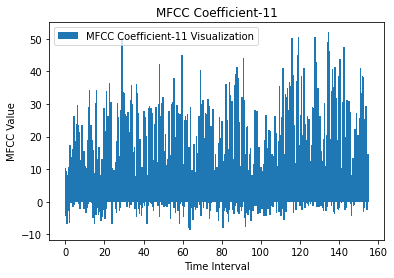

MFCC Values Variance for 11th Coefficent: 81.94891
Relative Time Distance between Max and Min values of 11th Coefficent: [71.04430193]


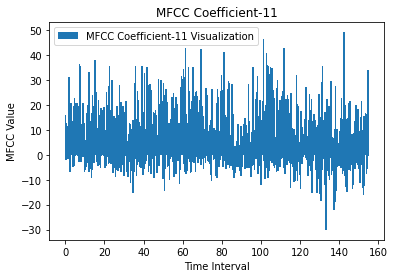

MFCC Values Variance for 11th Coefficent: 75.84579
Relative Time Distance between Max and Min values of 11th Coefficent: [9.1475343]


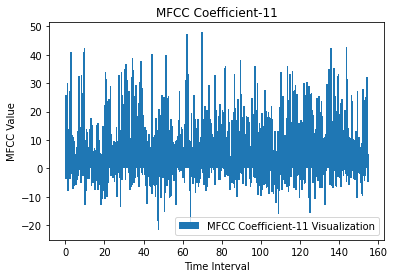

MFCC Values Variance for 11th Coefficent: 72.63402
Relative Time Distance between Max and Min values of 11th Coefficent: [22.1258888]


In [6]:
'''
Feature #6 from Marmar Paper (Flatter speech): 
variance of a specific spectral feature (11th LMFCC coefficient)
'''
'''
Feature #8 from Marmar Paper (Speech segments with very low activation): 
relative time distance between the occurrence of
the minimum and the maximum value for a specific spectral feature (11th LMFCC
coefficient) representing variability in certain speech frequencies.
'''


# For SUD-70 Audio
mfcc_visualize(mfccs_min_sud, 11)
print("MFCC Values Variance for 11th Coefficent: "+str(mfcc_variance(mfccs_min_sud, 11)))
print("Relative Time Distance between Max and Min values of 11th Coefficent: "+str(mfcc_max_min_time_distance(mfccs_min_sud, 11)))

# For SUD-85 Audio
mfcc_visualize(mfccs_medium_sud, 11)
print("MFCC Values Variance for 11th Coefficent: "+str(mfcc_variance(mfccs_medium_sud, 11)))
print("Relative Time Distance between Max and Min values of 11th Coefficent: "+str(mfcc_max_min_time_distance(mfccs_medium_sud, 11)))

# For SUD-90 Audio
mfcc_visualize(mfccs_high_sud, 11)
print("MFCC Values Variance for 11th Coefficent: "+str(mfcc_variance(mfccs_high_sud, 11)))
print("Relative Time Distance between Max and Min values of 11th Coefficent: "+str(mfcc_max_min_time_distance(mfccs_high_sud, 11)))

## Conclusion for MFCC 11th Coefficient:

Although we see a valley in time distance values, we can also see that Higher the SUD, LESSER is the variance in the 11th MFCC value. There is LOWER variability in certain speech frequencies when SUD is higher.

The Marmar paper used this metric in order to determine if the patient is PTSD +ve or -ve, and interestingly, we see that high SUD values lesser in lower variability.

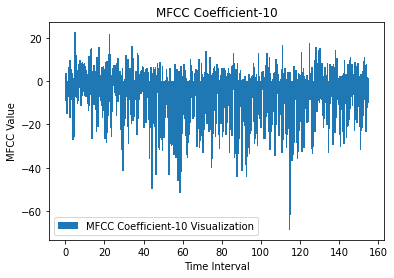

MFCC Values Variance for 10th Coefficent: 92.053764


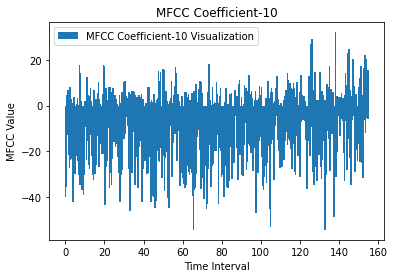

MFCC Values Variance for 10th Coefficent: 133.17143


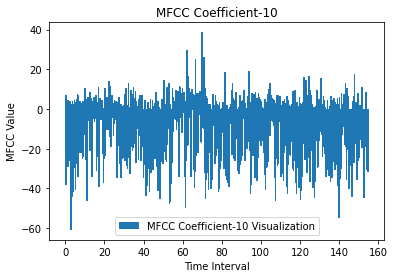

MFCC Values Variance for 10th Coefficent: 142.27647


In [7]:
'''
Feature #12 from Marmar Paper (Flatter speech in terms of energy variation): 
variance of a specific spectral feature (10th LMFCC coefficient)
'''

# For SUD-70 Audio
mfcc_visualize(mfccs_min_sud, 10)
print("MFCC Values Variance for 10th Coefficent: "+str(mfcc_variance(mfccs_min_sud, 10)))

# For SUD-85 Audio
mfcc_visualize(mfccs_medium_sud, 10)
print("MFCC Values Variance for 10th Coefficent: "+str(mfcc_variance(mfccs_medium_sud, 10)))

# For SUD-90 Audio
mfcc_visualize(mfccs_high_sud, 10)
print("MFCC Values Variance for 10th Coefficent: "+str(mfcc_variance(mfccs_high_sud, 10)))

## Conclusion for MFCC 10th Coefficient:

According to the Marmar Paper, the 10th coefficient is a measure of flatter speech in terms of energy. And although the paper suggests that people with flatter speech (i.e, less variation in energy) are more prone to PTSD, the results we got above are in direct contrast. 

We see that, higher the SUD value, MORE is the variance in 10th coefficient.

This seems like a conflict with what Marmar paper suggests. 

# Feature Extraction: Zero Crossings (ZC)

The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds like those in metal and rock.

Neither discussed in Marmar or Wiegersma papers, but I was curious to see how they vary for different SUD values.

In [10]:
# Helper Functions
'''
Creating Helper Function that calculates the Variance of ZC Values. 
    Param1: The ZC Array
'''
def zc_variance(zero_crossings):
    return np.var(zero_crossings, dtype = np.float32)

In [13]:
# For SUD-70 Audio
zero_crossings_min_sud = librosa.zero_crossings(min_sud_audio, pad=False)
print("Zero Crossings for SUD-70 Audio: "+str(sum(zero_crossings_min_sud)))
print("Variance of Zero Crossings for SUD-70 Audio: "+str(zc_variance(zero_crossings_min_sud))+"\n")

# For SUD-85 Audio
zero_crossings_medium_sud = librosa.zero_crossings(medium_sud_audio, pad=False)
print("Zero Crossings for SUD-85 Audio: "+str(sum(zero_crossings_medium_sud)))
print("Variance of Zero Crossings for SUD-85 Audio: "+str(zc_variance(zero_crossings_medium_sud))+"\n")

# For SUD-90 Audio
zero_crossings_high_sud = librosa.zero_crossings(high_sud_audio, pad=False)
print("Zero Crossings for SUD-90 Audio: "+str(sum(zero_crossings_high_sud)))
print("Variance of Zero Crossings for SUD-90 Audio: "+str(zc_variance(zero_crossings_high_sud)))

Zero Crossings for SUD-70 Audio: 224211
Variance of Zero Crossings for SUD-70 Audio: 0.0613506

Zero Crossings for SUD-85 Audio: 388674
Variance of Zero Crossings for SUD-85 Audio: 0.10087

Zero Crossings for SUD-90 Audio: 348718
Variance of Zero Crossings for SUD-90 Audio: 0.091695495


## Conclusion for Zero Crossings (ZC):

Interesting stuff! ZC is a measure of noisiness of a signal. It's known to have HIGHER variance for music-like audio segments, and LOWER variance for speech-like audio segments. 

From our observation above, we can see that higher the SUD value, HIGHER is the variance, i.e, indicating a MORE NOISY audio as SUDs increase. I believe this is happening due to the patient breaking down and crying at higher SUDs, thereby leading to more noisiness.

# Feature Extraction: Spectral Centroid (SC)

The spectral centroid indicates at which frequency the energy of a spectrum is centered upon or in other words It indicates where the **center of mass** for a sound is located.

Neither discussed in Marmar or Wiegersma papers, but I was curious to see how they vary for different SUD values.

In [14]:
# Helper Functions
'''
Creating Helper Function that normalizes. 
'''

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)


'''
Creating Helper Function that visualizes spectral centroids. 
'''
def centroid_visualize(audio):
    spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sample_rate)[0]
    # Computing the time variable for visualization
    plt.figure(figsize=(12, 4))
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    #Plotting the Spectral Centroid along the waveform
    librosa.display.waveplot(audio, sr=sample_rate, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='b')


'''
Creating Helper Function that calculates variance of spectral centroids. 
'''
def centroid_variance(audio):
    spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sample_rate)[0]
    return np.var(spectral_centroids, dtype = np.float32)

Variance of Spectral Centroids for SUD-70 audio: 752531.1
Variance of Spectral Centroids for SUD-85 audio: 954606.1
Variance of Spectral Centroids for SUD-90 audio: 752256.94


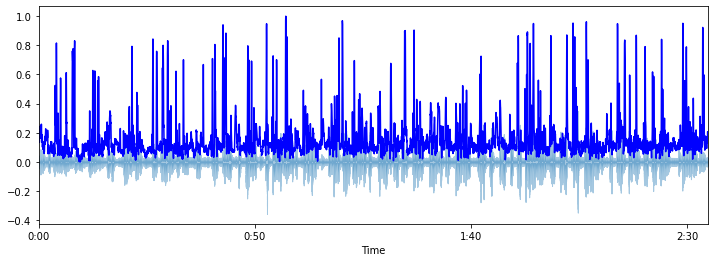

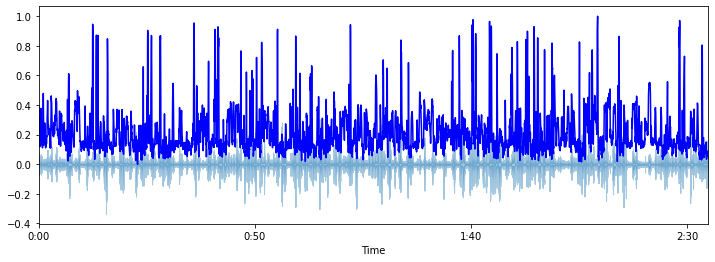

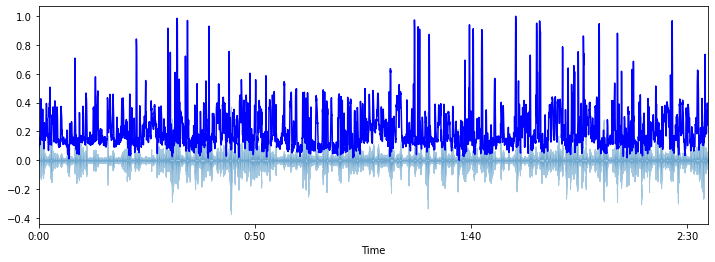

In [15]:
# For SUD-70 Audio
centroid_visualize(min_sud_audio)
print("Variance of Spectral Centroids for SUD-70 audio: "+str(centroid_variance(min_sud_audio)))

# For SUD-85 Audio
centroid_visualize(medium_sud_audio)
print("Variance of Spectral Centroids for SUD-85 audio: "+str(centroid_variance(medium_sud_audio)))

# For SUD-90 Audio
centroid_visualize(high_sud_audio)
print("Variance of Spectral Centroids for SUD-90 audio: "+str(centroid_variance(high_sud_audio)))

## Conclusion for Spectral Centroids (SC):

Spectral Centroid can be best thought of as the dominant frequency at a certain point of time. Now according to the Marmar paper, people with more monotonous speech (i.e, less variation in frequencies) are more prone to PTSD, but the results we got above are in direct contrast.

We see that, higher the SUD value, MORE is the variance in spectral centroid.

This seems like a conflict with what Marmar paper suggests. 

# Feature Extraction: Chroma 12 Pitch Scale 

In music, the term chroma feature or chromagram closely relates to the twelve different pitch classes.

The underlying observation is that humans perceive two musical pitches as similar in color if they differ by an octave. Based on this observation, a pitch can be separated into two components, which are referred to as tone height and chroma. Assuming the equal-tempered scale, one considers twelve chroma values represented by the set

{C, C♯, D, D♯, E , F, F♯, G, G♯, A, A♯, B}

The Marmar paper has extensively used this particular feature, so I too extracted it to check how Chroma FFT values differ accross audio files of different SUD values.

In [16]:
# Helper Functions
'''
Creating Helper Function that calculates Relative time distance between occurence of min and median chroma intensities. 
    Param1: Path to audio file
    Param2: Coefficient Number
'''
def chroma_max_min_time_distance(audio, coefficient_number):
    chromagram = librosa.feature.chroma_stft(audio, sr=sample_rate, hop_length=512)
    n_frames = chromagram.shape[1]
    first_chroma_fft_coefficient = np.sort(chromagram[coefficient_number])
    low_energy_frame = first_chroma_fft_coefficient[0]
    median_energy_frame = first_chroma_fft_coefficient[int(n_frames/2)]
    low_energy_time = (np.where(chromagram[coefficient_number] == low_energy_frame)[0])*(512/sample_rate)
    median_energy_time = (np.where(chromagram[coefficient_number] == median_energy_frame)[0])*(512/sample_rate)
    relative_time_distance = abs(low_energy_time - median_energy_time)
    return relative_time_distance

'''
Creating Helper Function that calculates kurtosis of the chromagram. 
    Param1: Path to audio file
    Param2: Coefficient Number
'''

def chroma_kurtosis(audio, coefficient_number):
    chromagram = librosa.feature.chroma_stft(audio, sr=sample_rate, hop_length=512)
    return kurtosis(chromagram[coefficient_number])

In [17]:
# Feature Extraction
'''
Feature #1 from Marmar Paper: 
Relative time distance between the occurrence of
the low (5%) and median (50%) values for a specific spectral feature (first chroma
FFT coefficient), representing variability in certain speech frequencies.
'''

# For SUD-70 Audio
print("Relative Time Distance for Low and Median values of first Chroma FFT for SUD-70 Audio: "+str(chroma_max_min_time_distance(min_sud_audio, 1)))

# For SUD-85 Audio
print("Relative Time Distance for Low and Median values of first Chroma FFT for SUD-85 Audio: "+str(chroma_max_min_time_distance(medium_sud_audio, 1)))

# For SUD-90 Audio
print("Relative Time Distance for Low and Median values of first Chroma FFT for SUD-90 Audio: "+str(chroma_max_min_time_distance(high_sud_audio, 1)))


Relative Time Distance for Low and Median values of first Chroma FFT for SUD-70 Audio: [34.38875283]
Relative Time Distance for Low and Median values of first Chroma FFT for SUD-85 Audio: [19.89950113]
Relative Time Distance for Low and Median values of first Chroma FFT for SUD-90 Audio: [45.9755102]


In [18]:
# Feature Extraction
'''
Feature #5 from Marmar Paper (Less bursty (more monotonous) voice): 
Kurtosis value for a specific spectral feature (third
Chroma filter) detecting existence of anomalies/outliers in the distribution of
certain speech frequencies.
'''

# For SUD-70 Audio
print("Kurtosis of third Chroma FFT for SUD-70 Audio: "+str(chroma_kurtosis(min_sud_audio, 3)))

# For SUD-85 Audio
print("Kurtosis of third Chroma FFT for SUD-85 Audio: "+str(chroma_kurtosis(medium_sud_audio, 3)))

# For SUD-90 Audio
print("Kurtosis of third Chroma FFT for SUD-90 Audio: "+str(chroma_kurtosis(high_sud_audio, 3)))

Kurtosis of third Chroma FFT for SUD-70 Audio: -1.2991169711536141
Kurtosis of third Chroma FFT for SUD-85 Audio: -0.5087401672153389
Kurtosis of third Chroma FFT for SUD-90 Audio: -0.8590093039403301


## Conclusion for Chroma Features:

It's difficult to point out any observations as such, since we see no general trend here. Maybe analyzing the audio of another session might help to discover some trend. 

According to my intuition (developed from the Marmar paper), the time distance between Low and Median values of first Chroma FFT should increase as SUD increases, as that would indicate lower variability in certain speech frequencies.

# Feature Extraction: RMS Energy

The energy of a signal corresponds to the total magntiude of the signal. For audio signals, that roughly corresponds to how loud the signal is. The RMS energy is just the root mean square of that energy.

Neither discussed in Marmar or Wiegersma papers, but I was curious to see how they vary for different SUD values.

In [27]:
# Helper Functions
'''
Creating Helper Function that visualizes energy and RMSE 
    Param1: Audio
'''
def rmse_visualize(audio):
    
    hop_length = 256
    frame_length = 512

    # compute RMSE over frames
    rmse = librosa.feature.rms(audio, frame_length=frame_length, hop_length=hop_length, center=True)
    rmse = rmse[0]

    # plot energy and rmse along the waveform
    frames = range(len(rmse))
    t = librosa.frames_to_time(frames, sr=sample_rate, hop_length=hop_length)

    plt.figure(figsize=(15, 5))
    librosa.display.waveplot(min_sud_audio, sr=sample_rate, alpha=0.4)
    
    plt.plot(t[:len(rmse)], rmse/rmse.max(), color='blue') # normalized for visualization
    plt.legend(('RMSE'))
    
'''
Creating Helper Function that calculates variance in RMSE values 
    Param1: Audio
'''
def rmse_variance(audio):
    hop_length = 256
    frame_length = 512

    rmse = librosa.feature.rms(audio, frame_length=frame_length, hop_length=hop_length, center=True)
    rmse = rmse[0]

    return np.var(rmse, dtype = np.float32)    

RMS Energy Variance for SUD-70 Audio: 0.00022322049

RMS Energy Variance for SUD-85 Audio: 0.0002569095

RMS Energy Variance for SUD-90 Audio: 0.0002255187



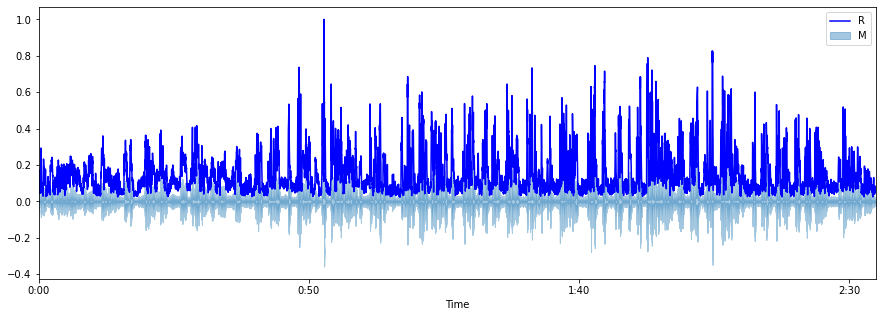

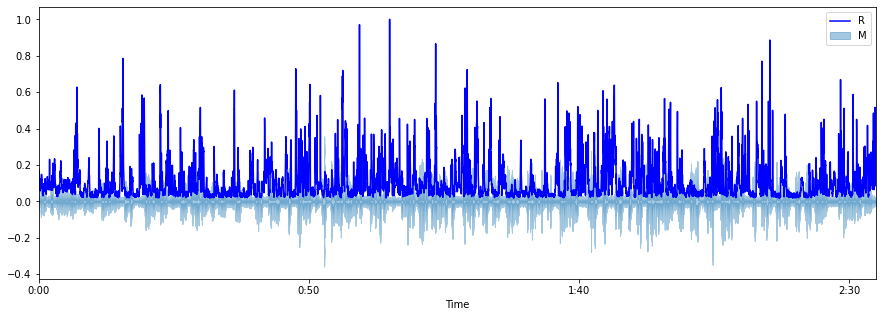

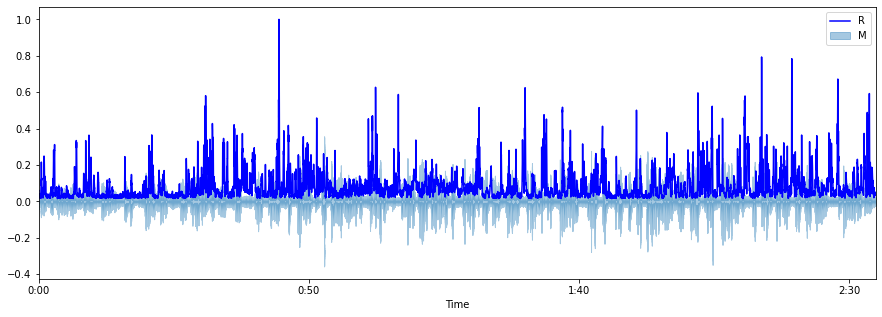

In [28]:
# For SUD-70 Audio
rmse_visualize(min_sud_audio)
print("RMS Energy Variance for SUD-70 Audio: "+str(rmse_variance(min_sud_audio))+"\n")

# For SUD-85 Audio
rmse_visualize(medium_sud_audio)
print("RMS Energy Variance for SUD-85 Audio: "+str(rmse_variance(medium_sud_audio))+"\n")

# For SUD-90 Audio
rmse_visualize(high_sud_audio)
print("RMS Energy Variance for SUD-90 Audio: "+str(rmse_variance(high_sud_audio))+"\n")

## Conclusion for RMS Energy:

It's difficult to point out any observations as such, since we see no general trend here. Maybe analyzing the audio of another session might help to discover some trend. 

Again, according to my intuition, RMS Energy's variance should DECREASE with higher SUDs. 

# Feature Extraction: Spectral Rolloff

Spectral rolloff is the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.

Neither discussed in Marmar or Wiegersma papers, but I was curious to see how they vary for different SUD values.

In [29]:
# Helper Function
'''
Creating Helper Function that visulaizes spectral rolloff 
    Param1: Audio
'''
def rolloff_visualize(audio):
    spectral_rolloff = librosa.feature.spectral_rolloff(audio+0.01, sr=sample_rate)[0]
    librosa.display.waveplot(audio, sr=sample_rate, alpha=0.4)
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    plt.plot(t, spectral_rolloff, color='r')

'''
Creating Helper Function that calculates variance of the calculated rolloffs. 
    Param1: Audio
'''

def rolloff_variance(audio):
    spectral_rolloff = librosa.feature.spectral_rolloff(audio+0.01, sr=sample_rate)[0]
    return np.var(spectral_rolloff, dtype = np.float32)

Rolloff Variance for SUD-70 Audio: 2671165.5


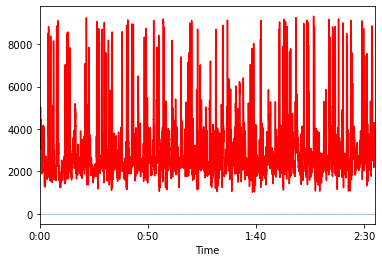

In [30]:
# For SUD-70 Audio
rolloff_visualize(min_sud_audio)
print("Rolloff Variance for SUD-70 Audio: "+str(rolloff_variance(min_sud_audio)))

Rolloff Variance for SUD-85 Audio: 3355560.0


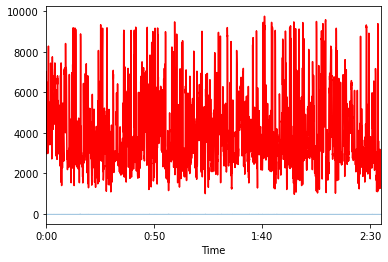

In [31]:
# For SUD-85 Audio
rolloff_visualize(medium_sud_audio)
print("Rolloff Variance for SUD-85 Audio: "+str(rolloff_variance(medium_sud_audio)))

Rolloff Variance for SUD-90 Audio: 3064579.2


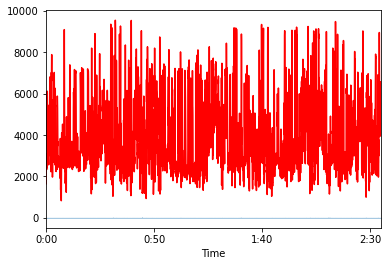

In [32]:
# For SUD-90 Audio
rolloff_visualize(high_sud_audio)
print("Rolloff Variance for SUD-90 Audio: "+str(rolloff_variance(high_sud_audio)))

## Conclusion for Spectral Rolloff (SR):

It's difficult to point out any observations as such, since we see no general trend here. Maybe analyzing the audio of another session might help to discover some trend. 

Again, according to my intuition, Rolloff variance should DECREASE with higher SUDs. 

# Feature Extraction: Spectrogram

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

I am yet to see how analyzing this feature can give us some insights, but for now, have just implemented it's visual representation to help me think in that direction.

In [33]:
# Helper Function
'''
Creating Helper Function that calculates variance of spectral centroids. 
'''
def spectrogram_visualize(audio):
    audio_spectrogram = librosa.stft(audio)
    audio_spectrogram_db = librosa.amplitude_to_db(abs(audio_spectrogram))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(audio_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

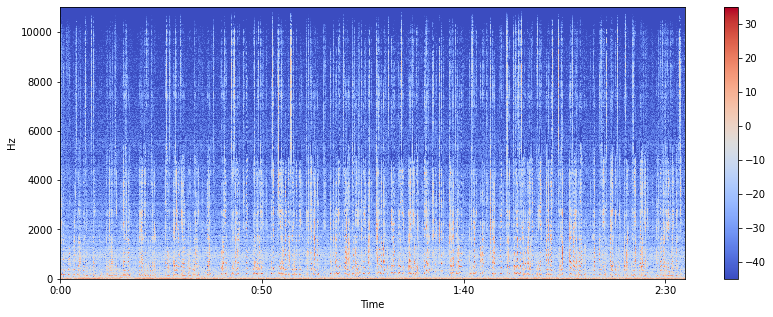

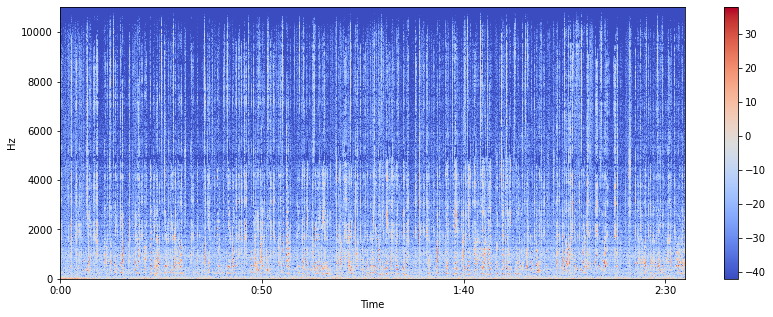

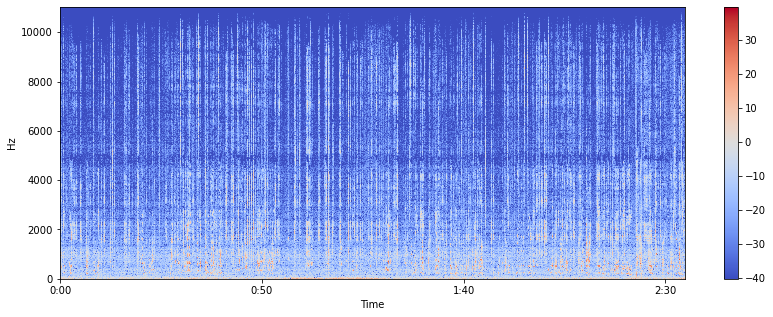

In [34]:
# For SUD-70 Audio
spectrogram_visualize(min_sud_audio)

# For SUD-85 Audio
spectrogram_visualize(medium_sud_audio)

# For SUD-90 Audio
spectrogram_visualize(high_sud_audio)

# Feature Extraction: Prosodic Features

Prosody refers to a collection of acoustic features that concern intonation-related (pitch), loudness-related
(intensity),and tempo-related(e.g. durational aspects, speaking rate) features. This can closely contribute to meaning and may reveal information normally not captured by textual features, such as emotional state or attitude.

The Wiegersma paper has used this particular feature for a certain part of their experiment, so I too extracted it to check how prosodic features values differ accross audio files of different SUD values.

In [51]:
# Helper Functions
'''
Creating Helper Function that calculates Prosodic Features for given audio file. 
    Param1: Path to audio file
'''
def find_prosodic_features(path):
    prosodic_features = {
        "phonation_rate" : 0,
        "speech_productivity" : 0,
        "speech_rate" : 0,
        "articulation_rate" : 0
    }
    
    audio_for_prosody, sample_rate = librosa.load(path, duration=audio_duration) 
    
    # Finding voiced intervals by removing silent parts of the audio
    voiced_intervals = librosa.effects.split(y=audio_for_prosody, top_db=20)
    total_voiced_duration = 0
    for interval in voiced_intervals:
        total_voiced_duration = total_voiced_duration + ((interval[1]-interval[0])/sample_rate)
    
    # To account for overflows
    if total_voiced_duration > audio_duration:
        total_voiced_duration = audio_duration
        
    total_silenced_duration = audio_duration-total_voiced_duration

    prosodic_features["phonation_rate"] = total_voiced_duration/audio_duration
    prosodic_features["speech_productivity"] = (total_silenced_duration)/total_voiced_duration

    # Reading Audio file as source
    # listening the audio file and store in audio_text variable
    r = sr.Recognizer()
    demo = sr.AudioFile(path)
    with demo as source:

        audio = r.record(source, duration=50)

        # recognize_() method will throw a request error if the API is unreachable, hence using exception handling
        try:

            # using google speech recognition
            text = r.recognize_google(audio)
            num_words_spoken = len(text.split())
            prosodic_features["speech_rate"] = num_words_spoken/audio_duration
            prosodic_features["articulation_rate"] = num_words_spoken/total_voiced_duration

        except:
             print('Error in Calculating speech rate and articulation rate')
    
    return prosodic_features

In [52]:
# For SUD-70 Audio
min_sud_prosodic_features = find_prosodic_features(filename1)
print("Prosodic Features for SUD-70 Audio: \n"+str(min_sud_prosodic_features)+"\n")

# For SUD-85 Audio
medium_sud_prosodic_features = find_prosodic_features(filename2)
print("Prosodic Features for SUD-85 Audio: \n"+str(medium_sud_prosodic_features)+"\n")

# For SUD-90 Audio
high_sud_prosodic_features = find_prosodic_features(filename3)
print("Prosodic Features for SUD-90 Audio: \n"+str(high_sud_prosodic_features)+"\n")

Prosodic Features for SUD-70 Audio: 
{'phonation_rate': 0.7638123023388546, 'speech_productivity': 0.3092221700775436, 'speech_rate': 0.232471031175074, 'articulation_rate': 0.3043562279151947}

Error in Calculating speech rate and articulation rate
Prosodic Features for SUD-85 Audio: 
{'phonation_rate': 0.5620149715092665, 'speech_productivity': 0.7793120302730441, 'speech_rate': 0, 'articulation_rate': 0}

Prosodic Features for SUD-90 Audio: 
{'phonation_rate': 0.38985315784864993, 'speech_productivity': 1.5650683593750017, 'speech_rate': 0.006457528643752056, 'articulation_rate': 0.016564002403846166}



## Conclusion for Prosodic Features:

These are features that I got to know about from the Wiegersma paper, and are really helpful for understanding the emotional state of the patient.

1. Phonation Rate: N(voiced minutes)/N(total minutes). The above observation shows that, for higher SUD values, the phonation rate drops, i.e, the patient is not able to speak much during higher SUDs.

2. Speech Productivity: N(silent minutes)/N(voiced minutes). The above observation shows that silent segments increase as SUD value increases.

3. Speech Rate: Words per minute. Speech rate decreased significantly for higher SUDs.

4. Articulation Rate: Words per voiced minute. Articulation rate decreased significantly for higher SUDs.

Indeed, these features give a good amount of insights into the emotional state of the patient!

# An Additional attempt to recognize emotion by using a third party library

As a small side experiment, I was experimenting with a ML model to see if we can predict emotions from audio. Currently, the training accuracy is just ~70%, so I don't completely trust the predictions. We can probably omit this avenue, or maybe work further to improve neural network accuracy. Just treat this as a proof of concept for now :)

In [53]:
from emotion_recognition import EmotionRecognizer
my_model = SVC()
# pass my model to EmotionRecognizer instance
# and balance the dataset
rec = EmotionRecognizer(model=my_model, emotions=['sad', 'neutral', 'fear'], balance=True, verbose=0)
# train the model
rec.train()
# check the test accuracy for that model
print("Test score:", rec.test_score())
# check the train accuracy for that model
print("Train score:", rec.train_score())

# prediction for SUD-70 Audio
print("Emotion Prediction for SUD-70 Audio:", rec.predict(filename1))

# prediction for SUD-85 Audio
print("Emotion Prediction for SUD-85 Audio:", rec.predict(filename2))

# prediction for SUD-90 Audio
print("Emotion Prediction for SUD-90 Audio:", rec.predict(filename3))

[+] Model trained
Test score: 0.6783216783216783
Train score: 0.7123809523809523
Emotion Prediction for SUD-70 Audio: fear
Emotion Prediction for SUD-85 Audio: fear
Emotion Prediction for SUD-90 Audio: fear
